In [0]:
!mkdir kaggle
!mkdir ~/.kaggle/
import json
token = {
    "username":"soumikrakshit",
    "key":"xxxx" # User your own kaggle key
}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d tryingit/roadlane-detection-evaluation-2013
!unzip roadlane-detection-evaluation-2013
!git clone https://github.com/soumik12345/FCN

 98% 442M/449M [00:14<00:00, 17.7MB/s]
100% 449M/449M [00:14<00:00, 32.4MB/s]
Archive:  roadlane-detection-evaluation-2013.zip
   creating: data_road/
   creating: data_road/training/
   creating: data_road/testing/
   creating: data_road/training/image_2/
  inflating: data_road/training/image_2/umm_000032.png  
  inflating: data_road/training/image_2/umm_000031.png  
  inflating: data_road/training/image_2/umm_000030.png  
  inflating: data_road/training/image_2/umm_000029.png  
  inflating: data_road/training/image_2/umm_000028.png  
  inflating: data_road/training/image_2/umm_000027.png  
  inflating: data_road/training/image_2/umm_000026.png  
  inflating: data_road/training/image_2/umm_000025.png  
  inflating: data_road/training/image_2/umm_000024.png  
  inflating: data_road/training/image_2/umm_000023.png  
  inflating: data_road/training/image_2/umm_000022.png  
  inflating: data_road/training/image_2/umm_000021.png  
  inflating: data_road/training/image_2/umm_000020.png  
  

In [3]:
import warnings, cv2
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os, scipy, re
from imageio import imread
from skimage.transform import resize
from glob import glob
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split

from FCN.models import ConvModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [0]:
def get_data(data_dir, image_shape):
    image_paths = glob(os.path.join(data_dir, 'image_2', '*.png'))
    label_paths = {
        re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
        for path in glob(os.path.join(data_dir, 'gt_image_2', '*_road_*.png'))}
    background_color = np.array([255, 0, 0])

    images = []
    gt_images = []
    for image_file in tqdm_notebook(image_paths):
        gt_image_file = label_paths[os.path.basename(image_file)]

        image = resize(cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB), image_shape)
        gt_image = resize(cv2.imread(gt_image_file), image_shape)

        images.append(image)
        gt_images.append(gt_image[:, :, 0])

    return np.array(images), np.expand_dims(np.array(gt_images), axis = 3)

In [5]:
x, y = get_data('./data_road/training', (160, 576))
x.shape, y.shape

((289, 160, 576, 3), (289, 160, 576, 1))

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((260, 160, 576, 3), (29, 160, 576, 3), (260, 160, 576, 1), (29, 160, 576, 1))

In [0]:
SEED = 42

image_data_generator = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    zoom_range = 0.1
).flow(x_train, x_train, 16, seed = SEED)

mask_data_generator = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    zoom_range = 0.1
).flow(y_train, y_train, 16, seed = SEED)

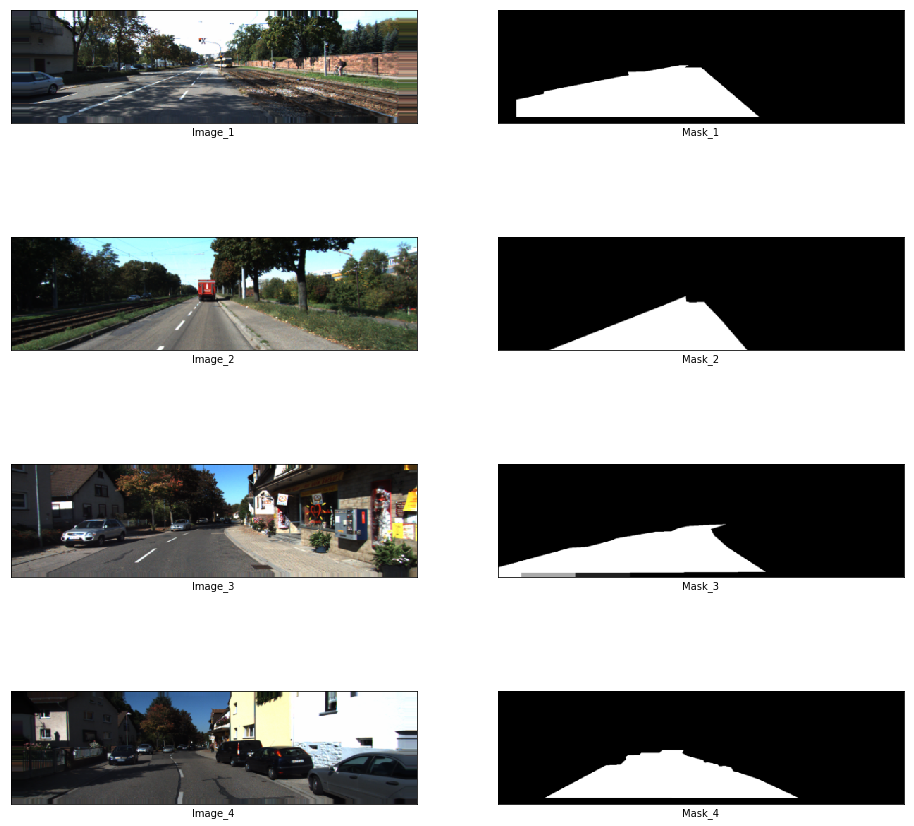

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
x_batch, _ = image_data_generator.next()
y_batch, _ = mask_data_generator.next()
c = 1
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(x_batch[c])
        ax.set_xlabel('Image_' + str(c))
    else:
        ax.imshow(y_batch[c].reshape(160, 576), cmap = 'gray')
        ax.set_xlabel('Mask_' + str(c))
        c += 1
plt.show()

In [9]:
fcn = ConvModel((160, 576, 3), pretrained = True)
fcn.summarize()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
58892288/58889256 [==============================] - 2s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 576, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 160, 576, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 160, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_p

In [0]:
# SVG(
#     model_to_dot(
#         fcn.model,
#         show_shapes = True,
#         show_layer_names = True
#     ).create(
#         prog = 'dot',
#         format = 'svg'
#     )
# )

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
fcn.model.compile(loss = dice_coef_loss, optimizer = Adam(lr = 1e-4), metrics = [dice_coef])

In [0]:
weight_saver = ModelCheckpoint(
    'model.h5',
    monitor = 'val_dice_coeff',
    save_best_only = True,
    mode = 'min',
    save_weights_only = True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5,
    patience = 3, verbose = 1,
    mode = 'min', min_delta = 0.0001,
    cooldown = 2, min_lr = 1e-6
)

early = EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 15
)

In [0]:
def data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [14]:
history = fcn.model.fit_generator(
    data_generator(
        image_data_generator,
        mask_data_generator
    ),
    validation_data = (x_val, y_val),
    steps_per_epoch = 200,
    epochs = 100,
    callbacks = [
        early,
        reduce_lr_on_plateau
    ]
)

Epoch 1/100
200/200 [==============================] - 198s 989ms/step - loss: -0.2941 - dice_coef: 0.2941 - val_loss: -0.3845 - val_dice_coef: 0.3845
Epoch 2/100
200/200 [==============================] - 182s 909ms/step - loss: -0.4057 - dice_coef: 0.4057 - val_loss: -0.4591 - val_dice_coef: 0.4591
Epoch 3/100
200/200 [==============================] - 182s 910ms/step - loss: -0.4950 - dice_coef: 0.4950 - val_loss: -0.5696 - val_dice_coef: 0.5696
Epoch 4/100
200/200 [==============================] - 182s 911ms/step - loss: -0.6344 - dice_coef: 0.6344 - val_loss: -0.7171 - val_dice_coef: 0.7171
Epoch 5/100
200/200 [==============================] - 183s 913ms/step - loss: -0.7451 - dice_coef: 0.7451 - val_loss: -0.7518 - val_dice_coef: 0.7518
Epoch 6/100
200/200 [==============================] - 182s 911ms/step - loss: -0.7813 - dice_coef: 0.7813 - val_loss: -0.7898 - val_dice_coef: 0.7898
Epoch 7/100
200/200 [==============================] - 182s 911ms/step - loss: -0.8461 - dice_

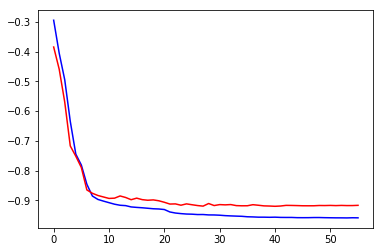

In [15]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.show()

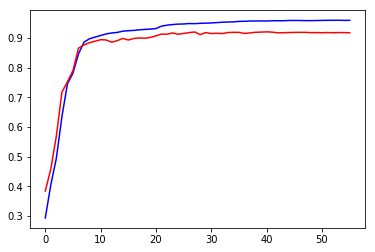

In [16]:
plt.plot(history.history['dice_coef'], color = 'b')
plt.plot(history.history['val_dice_coef'], color = 'r')
plt.show()

In [0]:
fcn.model.save('./model.h5')

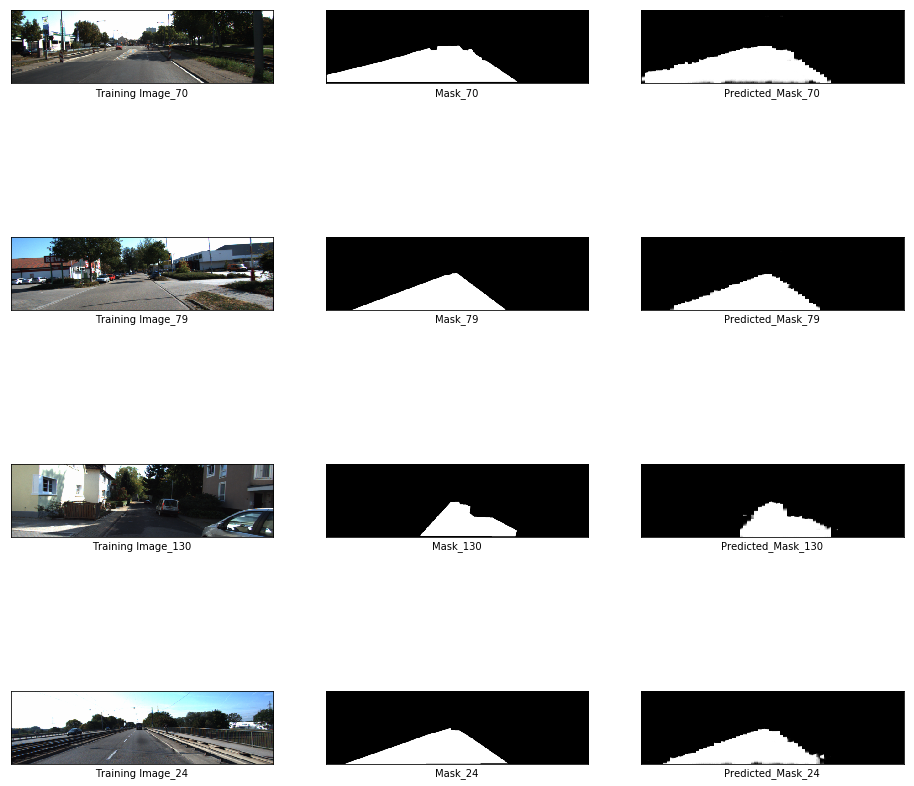

In [18]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
index = randint(0, len(x_train) - 1)
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        index = randint(0, len(x_train))
        ax.imshow(x_train[index])
        ax.set_xlabel('Training Image_' + str(index))
    elif i % 3 == 1:
        ax.imshow(y_train[index].reshape(160, 576), cmap = 'gray')
        ax.set_xlabel('Mask_' + str(index))
    elif i % 3 == 2:
        ax.imshow(fcn.model.predict(x_train[index].reshape(1, 160, 576, 3)).reshape(160, 576), cmap = 'gray')
        ax.set_xlabel('Predicted_Mask_' + str(index))
plt.show()